# Logistic regression and neural network
### Genesis Quiles-Galarza

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from pyDOE import *
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

**Consider a data set for binary classification containing around 3500 labeled images with resolution $200×200$ pixels. To facilitate faster computations, here we provide a compressed version of the original image data that contains only the 10 most dominant features obtained via principal component analysis. For all the following questions, we're going to split the data set into training data and testing data. The training data set should contain 3/4 of the data and the testing data set should contain 1/4 of the data.**

**We're going to implement a logistic regression model in PyTorch and report its testing and training accuracy.**


In [2]:
class LogisticRegression:
    def __init__(self,D_in,D_out):
        # Glorot initializer
        # Computes initial weights as a normal distribution and b=0
        w = np.random.normal(0, np.sqrt(2./(D_in + D_out)), D_in*D_out)
        b = np.zeros(D_out)
        
        self.w = (torch.from_numpy(w).type(torch.FloatTensor)).requires_grad_(True)
        self.b = (torch.from_numpy(b).type(torch.FloatTensor)).requires_grad_(True)
        self.loss_track = []
        
    def get_Loss(self,X,Y):
        # Calculate the Binary Cross entropy loss
        a = torch.sigmoid((torch.matmul(X,self.w) + self.b))
        n = X.shape[0]
        Loss =(Y*torch.log(a)).sum() + ((1-Y)*torch.log(1-a)).sum()
        Loss = -(1/n)*Loss
        return Loss
    
    def graddes(self,X,Y,lr,iterations):
        # Calculate w and b using gradient descent
        maxiter=iterations
        gam=0.9
        print('Beginning iterations...')
        for i in range(0,maxiter):
            err = self.get_Loss(X,Y)
            err.backward()
            with torch.no_grad():
                self.w -=lr*self.w.grad
                self.b -= lr*self.b.grad
                self.w.grad.zero_()
                self.b.grad.zero_()
            err = err.data.numpy()
            self.loss_track.append(err)
        return err

    def train(self,X,Y,lr,iterations):
        # optimize to get weights 
        t = time.time()
        err = self.graddes(X,Y,lr,iterations)
        elapsed = time.time() - t
        elapsed = np.around(elapsed,2)
        print('Completed '+str(iterations)+' iterations. Time elapsed: '+str(elapsed) + 's')
        return err

    def predictTest(self,X_test,Y_test):
        pyx = torch.sigmoid(torch.matmul(X_test,self.w) + self.b) #p(y|x) for the test data 
        pyx[pyx>=0.5] = 1
        pyx[pyx<0.5] = 0
        #Lets compare pyx with y_test
        accuracy = (1-len(torch.nonzero(pyx-Y_test))/(Y_test.shape[1]))*100
        return accuracy
    

In [2]:
# Load and split the test/train data
data = np.load("Data.npy", allow_pickle = True).item()
X = data["X"]
Y = data["Y"]

### from here below we can define functions

def get_data(X,Y,test_size):
    #Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=test_size)
    X_train = torch.tensor(X_train,dtype=torch.float)
    X_test = torch.tensor(X_test,dtype=torch.float)
    Y_train = torch.tensor(Y_train,dtype=torch.float)
    Y_test = torch.tensor(Y_test,dtype=torch.float)

    # normalize X-data to be zero-mean
    X_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
    X_test = (X_test - X_train.mean(axis=0))/X_train.std(axis=0)
    
    #Transpose the Y data
    Y_train = Y_train.t()
    Y_test = Y_test.t()
    return X_train, X_test, Y_train, Y_test

def make_plots(loss):
    plt.plot(loss)
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.show()
    
def logreg_model(test_size):
    lr = 0.002
    iterations = 10000
    X_train, X_test, Y_train, Y_test = get_data(X,Y,test_size)
    # create instance of Logistic Regression class
    logreg = LogisticRegression(len(X[0]),len(Y[0]))
    # Train the data
    err = logreg.train(X_train,Y_train,lr,iterations)
    # Get the accuracy of the model
    accuracy = logreg.predictTest(X_test,Y_test)
    loss = logreg.loss_track
    print("The training loss is:", err)
    print("The accuracy using",test_size,"of the data as test data is",np.around(accuracy,2),"%.")
    make_plots(loss)


Logistic Regression was implemented by using the Glorot Initializer to get initial values for $w$ and $b$. Gradient descent was used to optimize the $w$ and $b$ values, by iterating 10,000 times and using a learning rate of $\eta=0.002$. Finally, the loss was calculated by the Binary Cross Entropy Loss.

For a test size of 0.25:

Beginning iterations...
Completed 10000 iterations. Time elapsed: 4.38s
The training loss is: 0.38949412
The accuracy using 0.25 of the data as test data is 84.45 %.


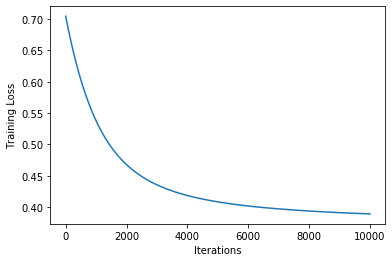

In [4]:
logreg_model(0.25)

Let's now vary the test sizes. Try test size = 0.20.

Beginning iterations...
Completed 10000 iterations. Time elapsed: 4.11s
The training loss is: 0.3910789
The accuracy using 0.2 of the data as test data is 83.43 %.


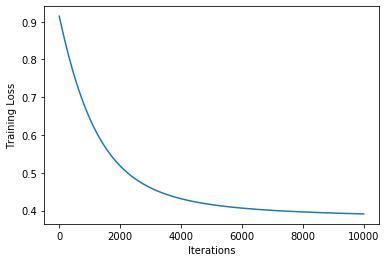

In [5]:
logreg_model(0.20)

Now let's try reducing the training data set by increasing the test size = 0.40. 

Beginning iterations...
Completed 10000 iterations. Time elapsed: 3.9s
The training loss is: 0.38911676
The accuracy using 0.4 of the data as test data is 83.14 %.


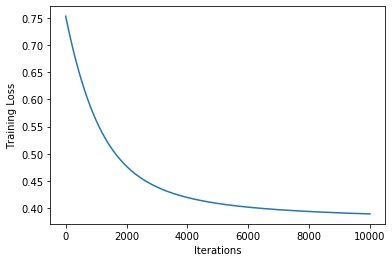

In [6]:
logreg_model(0.40)

Varying the test size using this method did not significantly change the result!
To improve this model, the loss could be minimized faster by using stochastic gradient descent with momentum or adaptive moment estimation.

# Neural Network

### Now, we will extend the model to a deep neural network with fully connected layers and repeat the previous task.

In [3]:
class NeuralNetwork:
    def __init__(self,D_in, D_out,L,Q,typ):
        self.D_in = D_in
        self.D_out = D_out
        self.typ = typ
        self.L = L # L = number of hidden layers
        self.Q = Q #Q = number of neurons in each layer, should be an array of length L
        self.layer = 0 #This will display the hidden layer we're currently in
        self.neurons = Q[self.layer]  #This will display how many neurons are in the hidden layer we're currently in.
        self.loss_track = [] #keeps track of the loss over iterations
        
    def glorot_init(self):
        D_in = self.D_in
        D_out = self.D_out
        w = np.zeros((D_in*D_out,self.Q[0],)) #W is d x Q
        b = np.zeros(self.Q[0]) # b is 1 x Q
        for i in range(0,self.Q[0]):
            w[:,i] = np.random.normal(0, np.sqrt(2./(D_in + D_out)), D_in*D_out)
        self.w = (torch.from_numpy(w).type(torch.FloatTensor)).requires_grad_(True)
        self.b = (torch.from_numpy(b).type(torch.FloatTensor)).requires_grad_(True)
    
    def reset_weights(self):
        #this will update the size of the weights based on which hidden layer we're in using Glorot Init.
        L = self.layer
        if L<self.L:
            dim = self.neurons
        elif L >= self.L:
            dim = self.D_out #output layer will give dimensions of w = [Q(L-1)x d_out=1]
        D_in = self.Q[L-1]
        D_out = self.D_out
        w = np.zeros((self.Q[L-1],dim)) #w is now Q(L-1) x Q(L)
        b = np.zeros(dim) # b is 1 x Q(L)
        for i in range(0,dim):
            w[:,i] = np.random.normal(0, np.sqrt(2./(D_in + D_out)), D_in*D_out)
        self.w = (torch.from_numpy(w).type(torch.FloatTensor)).requires_grad_(True)
        self.b = (torch.from_numpy(b).type(torch.FloatTensor)).requires_grad_(True)
    
    def get_BCE_Loss(self,X,Y):
        # Calculate the Binary Cross entropy loss
        a = torch.sigmoid(torch.matmul(X,self.w)+self.b)
        n = X.shape[0]
        Loss =(torch.matmul(Y,torch.log(a))).sum() + (torch.matmul((1-Y),torch.log(1-a))).sum()
        Loss = -(1/n)*Loss
        return Loss

    def act_func(self,X,w,b):
        if self.typ=='sig':
            H = torch.sigmoid(torch.matmul(X,w)+b)
        elif self.typ=='tanh':
            H = torch.tanh(torch.matmul(X,w)+b)
        return H
        
    def graddes(self,X,Y,lr):
        # Calculate w and b using gradient descent
        maxiter= X.shape[0]*5
        print('Beginning iterations in Layer',self.layer)
        for i in range(0,maxiter):
            err = self.get_BCE_Loss(X,Y)
            self.loss_track.append(err)
            err.backward(retain_graph=True)
            with torch.no_grad():
                self.w -=lr*self.w.grad
                self.b -= lr*self.b.grad
                self.w.grad.zero_()
                self.b.grad.zero_()
            err = err.data.numpy()
            self.loss_track.append(err)
        H = self.act_func(X,self.w,self.b)
        print('Completed',maxiter,'iterations in Layer',self.layer,)
        return err, H
    
    def train(self,X,Y,lr):
        # optimize to get weights in each hidden layer
        self.glorot_init()
        L = self.L
        t = time.time()
        for i in range(0,L+1):
            err, H = self.graddes(X,Y,lr)
            X=H
            #w = self.w #save the weights after the training
            #b = self.b
            if self.layer == 0:
                w0 = self.w
                b0=self.b
            elif self.layer==1:
                w1 = self.w
                b1=self.b
            elif self.layer ==2:
                w2 = self.w
                b2 = self.b
            #could improve code here by making it universal, right now it's restribted to 2 hidden layers
            self.layer +=1
            if self.layer <= L:
                self.reset_weights() #reset for next iteration
        elapsed = time.time() - t
        elapsed = np.around(elapsed,2)
        print('Completed neural network training. Time elapsed: '+str(elapsed) + 's')
        return err, w0, b0, w1, b1, w2, b2
        
    def predictTest(self,X_test,Y_test,w0, b0, w1, b1, w2, b2):
        H0 = self.act_func(X_test,w0,b0)
        H1 = self.act_func(H0,w1,b1)
        pyx = self.act_func(H1,w2,b2)
        pyx = pyx.t()
        n = len(Y_test)
        if self.typ == 'sig':
            pyx[pyx>=0.5] = 1
            pyx[pyx<0.5] = 0
            #Lets compare pyx with y_test
            accuracy = (1-len(torch.nonzero(pyx-Y_test))/(Y_test.shape[1]))*100
        elif self.typ=='tanh':
            #calculate L2 norm
            accuracy = torch.sqrt(((pyx-Y_test)**2).sum())
            accuracy = (1/n)*accuracy
            accuracy = accuracy.data.numpy()
        pyx = pyx.data.numpy()
        return accuracy, pyx
    

In [4]:
def nn_model2(test_size):
    lr = 0.002
    X_train, X_test, Y_train, Y_test = get_data(X,Y,test_size)
    # create instance of Logistic Regression class
    typ = 'sig' # choosing activation function as sigmoid
    L = 2 # choosing two hidden layers
    Q = [25,25] # each hidden layer will have 25 neurons
    nnmod = NeuralNetwork(len(X[0]),len(Y[0]),L,Q,typ)
    # Train the data
    err, w0, b0, w1, b1, w2, b2 = nnmod.train(X_train,Y_train,lr)
    # Get the accuracy of the model
    accuracy, pyx = nnmod.predictTest(X_test,Y_test,w0, b0, w1, b1, w2, b2)
    loss = nnmod.loss_track
    print("The training loss is:", err)
    print("The accuracy using",test_size,"of the data as test data is",np.around(accuracy,2),"%.")
    make_plots(loss)

The Neural Network was initialized using Glorot Initialization, and the activation function used was a sigmoid function. Two hidden layers were used, with 25 neurons each. Gradient descent was used to optimize the $w$ and $b$ values in each hidden layer, by iterating 5n ~ 13,000 times and using a learning rate of $\eta=0.002$. Finally, the loss was calculated by the Binary Cross Entropy Loss.

The model prints out updates on the status of the calculation, so that while it is running the user can see what the model is doing. I incorporated this feature because it was taking some time to run.

For a test size of 0.25:

Beginning iterations in Layer 0
Completed 13005 iterations in Layer 0
Beginning iterations in Layer 1
Completed 13005 iterations in Layer 1
Beginning iterations in Layer 2
Completed 13005 iterations in Layer 2
Completed neural network training. Time elapsed: 110.75s
The training loss is: 0.43179914
The accuracy using 0.25 of the data as test data is 83.18 %.


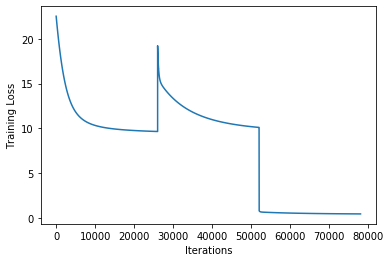

In [7]:
nn_model2(0.25)

Now let's try varying the test size, like earlier. Let's increase the model to train using 80% of the training data.

Beginning iterations in Layer 0
Completed 13875 iterations in Layer 0
Beginning iterations in Layer 1
Completed 13875 iterations in Layer 1
Beginning iterations in Layer 2
Completed 13875 iterations in Layer 2
Completed neural network training. Time elapsed: 90.1s
The training loss is: 0.42817086
The accuracy using 0.2 of the data as test data is 84.44 %.


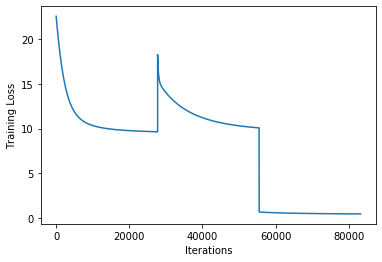

In [6]:
nn_model2(0.20)

Let's make the model train using only 60% of the training data.

Beginning iterations in Layer 0
Completed 10405 iterations in Layer 0
Beginning iterations in Layer 1
Completed 10405 iterations in Layer 1
Beginning iterations in Layer 2
Completed 10405 iterations in Layer 2
Completed neural network training. Time elapsed: 72.44s
The training loss is: 0.45175177
The accuracy using 0.4 of the data as test data is 82.56 %.


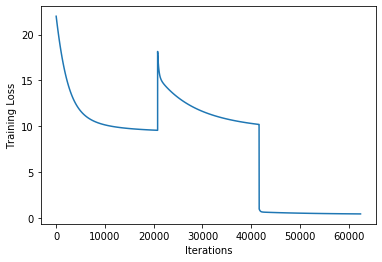

In [7]:
nn_model2(0.40)

Again, just like when using the regression model, changing the size of the data did not seem to change the accuracy significantly. Implemented in a real life situation, the basic logistic regression model should work fine, especially as it is quicker and provides a similar level of accuracy.

Additionally, this model used GD as the optimizer. It converges quite slowly, and even after the first hidden layer, had some issues converging. This can be seen in the noticable peaks in the plots. After the first peak, the loss isn't minimized any further than it already was in the first hidden layer. To improve how quickly the loss is minimized, a more efficient optimizer can be used, such as incorporating momentum or using ADAM. Alternatively, the learning rate can be adjusted.